#FAIRNESS IN RECIDIVISM PREDICTION MODELS

#Installing Fairlearn in Colab Notebook

In [ ]:
!pip install fairlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 2.7 MB/s eta 0:00:00


# Importing libraries and Loading Dataset

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import classification_report
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds
from fairlearn.metrics import equalized_odds_difference

data = pd.read_csv('https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years.csv')

In [ ]:
print(data)

         id                 name      first         last  \
0         1     miguel hernandez     miguel    hernandez   
1         3          kevon dixon      kevon        dixon   
2         4             ed philo         ed        philo   
3         5          marcu brown      marcu        brown   
4         6   bouthy pierrelouis     bouthy  pierrelouis   
...     ...                  ...        ...          ...   
7209  10996        steven butler     steven       butler   
7210  10997      malcolm simmons    malcolm      simmons   
7211  10999      winston gregory    winston      gregory   
7212  11000          farrah jean     farrah         jean   
7213  11001  florencia sanmartin  florencia    sanmartin   

     compas_screening_date     sex         dob  age          age_cat  \
0               2013-08-14    Male  1947-04-18   69  Greater than 45   
1               2013-01-27    Male  1982-01-22   34          25 - 45   
2               2013-04-14    Male  1991-05-14   24     Less th

In [ ]:
data.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

In [ ]:
# get numeric columns
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns.tolist()

# get categorical columns
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
print("numeric",numeric_cols)
print("categorical",categorical_cols)

numeric ['id', 'age', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest', 'c_days_from_compas', 'is_recid', 'r_days_from_arrest', 'violent_recid', 'is_violent_recid', 'decile_score.1', 'v_decile_score', 'priors_count.1', 'start', 'end', 'event', 'two_year_recid']
categorical ['name', 'first', 'last', 'compas_screening_date', 'sex', 'dob', 'age_cat', 'race', 'c_jail_in', 'c_jail_out', 'c_case_number', 'c_offense_date', 'c_arrest_date', 'c_charge_degree', 'c_charge_desc', 'r_case_number', 'r_charge_degree', 'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out', 'vr_case_number', 'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc', 'type_of_assessment', 'score_text', 'screening_date', 'v_type_of_assessment', 'v_score_text', 'v_screening_date', 'in_custody', 'out_custody']


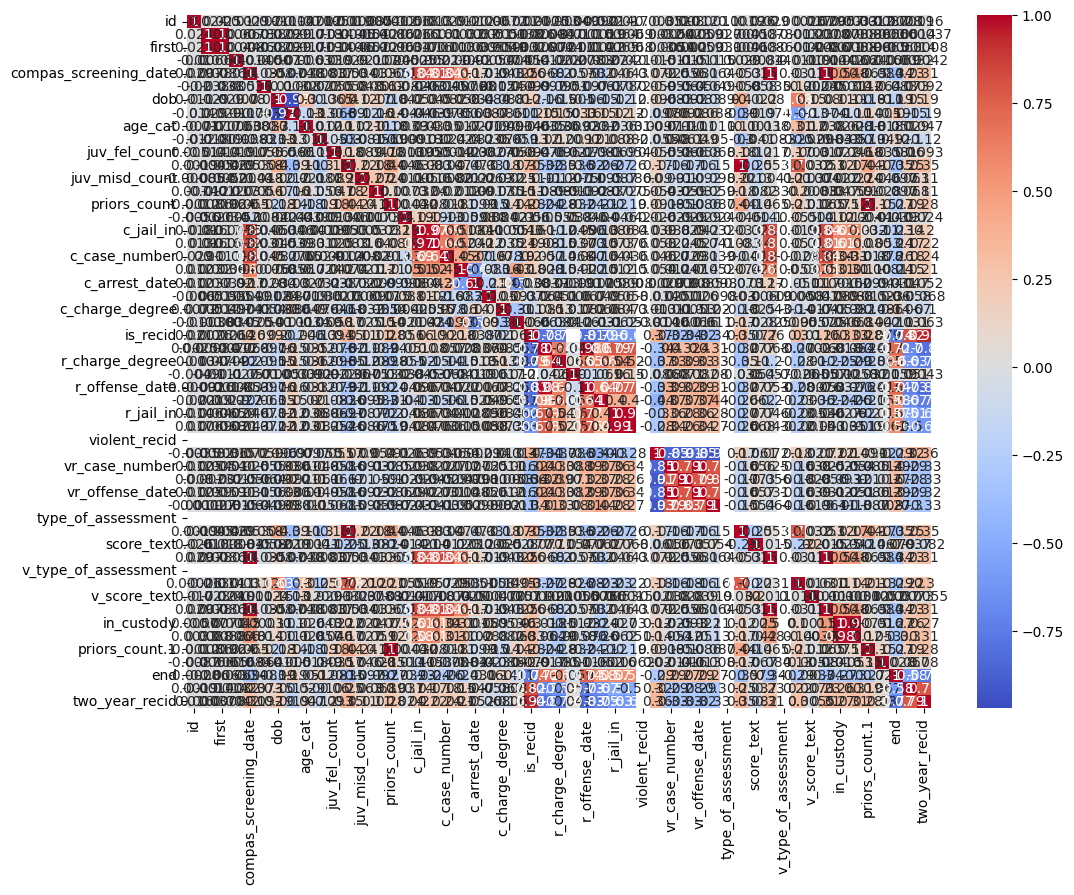

In [ ]:
# Initialize the LabelEncoder
encoder = LabelEncoder()

# Iterate through each categorical column and apply label encoding
categorical_columns = ['name', 'first', 'last', 'compas_screening_date', 'sex', 'dob', 'age_cat', 'race', 'c_jail_in', 'c_jail_out', 'c_case_number', 'c_offense_date', 'c_arrest_date', 'c_charge_degree', 'c_charge_desc', 'r_case_number', 'r_charge_degree', 'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out', 'vr_case_number', 'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc', 'type_of_assessment', 'score_text', 'screening_date', 'v_type_of_assessment', 'v_score_text', 'v_screening_date', 'in_custody', 'out_custody']  # Replace with the names of your categorical columns
for column in categorical_columns:
    data[column] = encoder.fit_transform(data[column])
  
# Select only numeric columns
numeric_data = data.select_dtypes(include=[np.number])

correlation_matrix = numeric_data.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


#Selecting important features for predicting recidivism

In [ ]:
df = data[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 
                    'days_b_screening_arrest', 'decile_score','juv_fel_count','juv_misd_count','juv_other_count', 
                    'c_jail_in', 'c_jail_out','two_year_recid' ]]

In [ ]:
df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])
df['length_of_stay'] = (df['c_jail_out'] - df['c_jail_in']).dt.days.astype(float)
df = df.drop('c_jail_in', axis=1)
df = df.drop('c_jail_out', axis=1)

<ipython-input-12-bfbec8010b70>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
<ipython-input-12-bfbec8010b70>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])
<ipython-input-12-bfbec8010b70>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

In [ ]:
df = df[(df['days_b_screening_arrest'] <= 30) & (df['days_b_screening_arrest'] >= -30)]

In [ ]:
# get numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# get categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

In [ ]:
# Initialize the LabelEncoder
encoder = LabelEncoder()

# Iterate through each categorical column and apply label encoding
categorical_columns = ['c_charge_degree', 'race', 'age_cat', 'score_text', 'sex']  # Replace with the names of your categorical columns
for column in categorical_columns:
    df[column] = encoder.fit_transform(df[column])
    

In [ ]:
# Select only numeric columns
numeric_data = df.select_dtypes(include=[np.number])

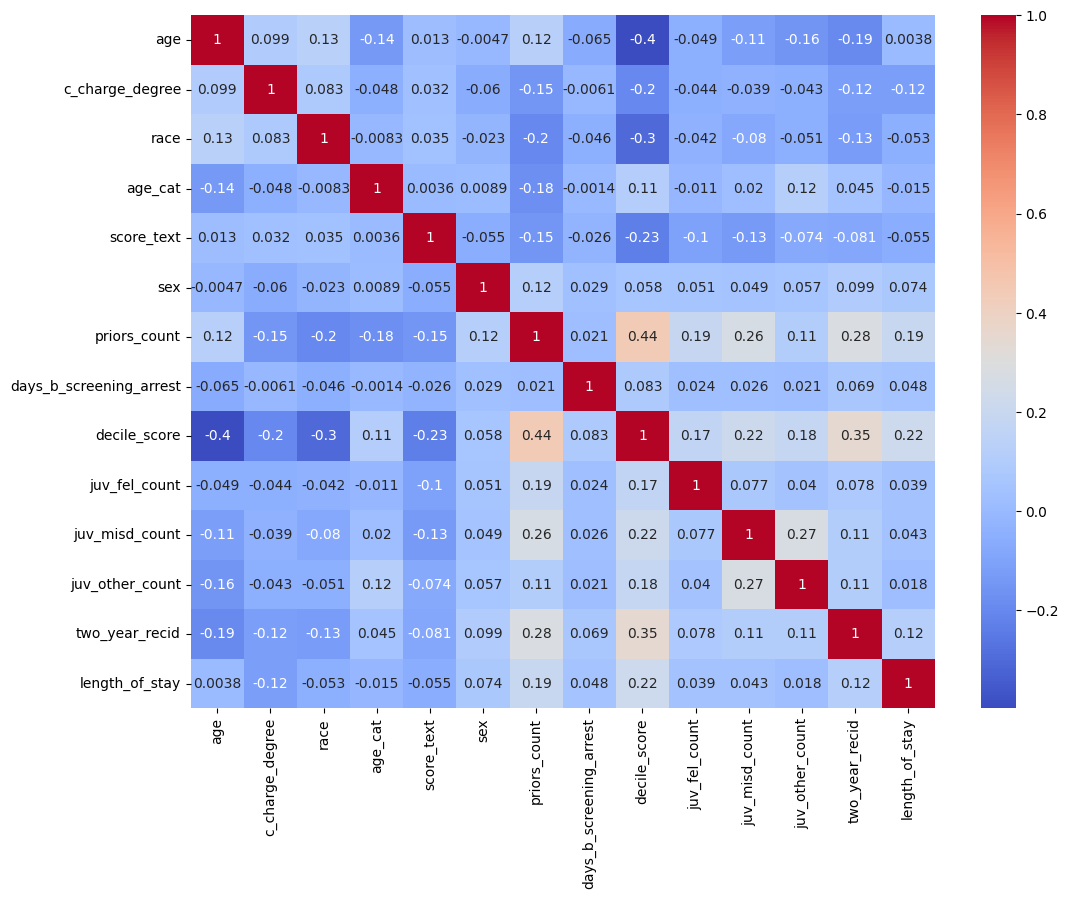

In [ ]:
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


In [ ]:
# Fill missing values with median
datas = numeric_data.fillna(numeric_data.median())

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = datas.drop('two_year_recid', axis=1)
y = datas['two_year_recid']

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

best_features = SelectKBest(score_func=chi2, k='all') # Select the top 10 features

fit = best_features.fit(X_scaled, y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)

# Concatenate the two dataframes and sort them by the score
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature', 'Score']
print(feature_scores.nlargest(54, 'Score')) # Print the top 10 features

                    Feature       Score
8              decile_score  207.400114
6              priors_count   92.823430
12           length_of_stay   79.761842
1           c_charge_degree   54.909530
2                      race   34.184577
0                       age   25.885614
10           juv_misd_count   16.258450
5                       sex   12.100340
11          juv_other_count   10.648559
4                score_text    8.779599
9             juv_fel_count    7.131320
3                   age_cat    6.796781
7   days_b_screening_arrest    0.453918


In [ ]:
# Select features and target
X = datas.drop('two_year_recid', axis=1)
y = datas['two_year_recid']

# Perform the train-test split
X_train, X_test, y_train, y_test, race_tr, race_te = train_test_split(X, y, X['race'], test_size=0.33, random_state=42)


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(),
    'k-NN': KNeighborsClassifier(),
    'MLP': MLPClassifier()
}


In [ ]:
for name, classifier in classifiers.items():
    if name in ['SVM', 'k-NN', 'MLP']:
        classifier.fit(X_train_scaled, y_train)
        y_pred = classifier.predict(X_test_scaled)
    else:
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} - Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print("\n" + "="*80 + "\n")


Logistic Regression - Accuracy: 0.6854
              precision    recall  f1-score   support

           0       0.69      0.78      0.73      1194
           1       0.67      0.57      0.61       945

    accuracy                           0.69      2139
   macro avg       0.68      0.67      0.67      2139
weighted avg       0.68      0.69      0.68      2139

[[930 264]
 [409 536]]


Decision Tree - Accuracy: 0.5825
              precision    recall  f1-score   support

           0       0.63      0.62      0.63      1194
           1       0.53      0.53      0.53       945

    accuracy                           0.58      2139
   macro avg       0.58      0.58      0.58      2139
weighted avg       0.58      0.58      0.58      2139

[[746 448]
 [445 500]]


Random Forest - Accuracy: 0.6550
              precision    recall  f1-score   support

           0       0.69      0.70      0.69      1194
           1       0.61      0.60      0.61       945

    accuracy               

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# Train and evaluate the best classifier on the test set
best_classifier = GradientBoostingClassifier() 
best_classifier.fit(X_train, y_train)
y_pred = best_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Best classifier - Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])

# Calculate the counts of true positives, true negatives, false positives, and false negatives
tp = cm_df.loc['Actual Positive', 'Predicted Positive']
tn = cm_df.loc['Actual Negative', 'Predicted Negative']
fp = cm_df.loc['Actual Negative', 'Predicted Positive']
fn = cm_df.loc['Actual Positive', 'Predicted Negative']

# Print the confusion matrix with counts of true positives, true negatives, false positives, and false negatives
print(f"Confusion Matrix:\n{cm_df}\n")
print(f"True Positives: {tp}")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")

Best classifier - Accuracy: 0.6830
              precision    recall  f1-score   support

           0       0.70      0.76      0.73      1194
           1       0.66      0.59      0.62       945

    accuracy                           0.68      2139
   macro avg       0.68      0.67      0.67      2139
weighted avg       0.68      0.68      0.68      2139

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                 906                 288
Actual Positive                 390                 555

True Positives: 555
True Negatives: 906
False Positives: 288
False Negatives: 390


# Question 1

In [ ]:
results = pd.DataFrame({"true_label": y_test, "predicted_label": y_pred, "race": X_test['race']})

# Get the list of unique races in the dataset
races = results['race'].unique()

print("0 - African American , 2 - Caucasian")
# Calculate the probability of a positive prediction for individuals who did not actually recidivate, for each race
for race in races:
    numerator = len(results[(results['race'] == race) & (results['true_label'] == 0) & (results['predicted_label'] == 1)])
    denominator = len(results[(results['race'] == race) & (results['true_label'] == 0)])
    prob_pos_pred = numerator / denominator
    print(f"Probability of a positive prediction for {race} individuals who did not actually recidivate: {prob_pos_pred:.2f} ({numerator}/{denominator})")


# 0 - African American , 2 - Caucasian

0 - African American , 2 - Caucasian
Probability of a positive prediction for 0 individuals who did not actually recidivate: 0.34 (185/540)
Probability of a positive prediction for 5 individuals who did not actually recidivate: 0.15 (13/84)
Probability of a positive prediction for 2 individuals who did not actually recidivate: 0.17 (76/440)
Probability of a positive prediction for 3 individuals who did not actually recidivate: 0.12 (14/121)
Probability of a positive prediction for 4 individuals who did not actually recidivate: 0.00 (0/2)
Probability of a positive prediction for 1 individuals who did not actually recidivate: 0.00 (0/7)


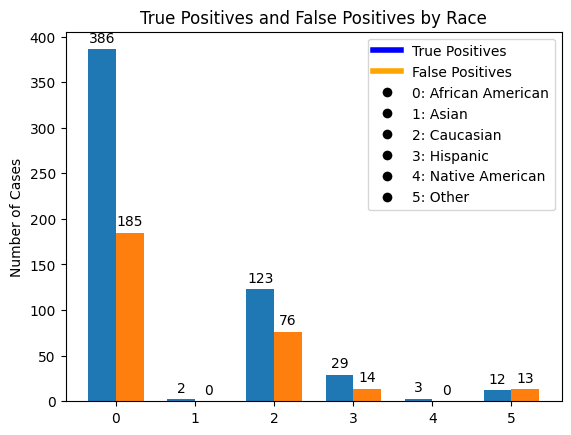

In [ ]:
import numpy as np

# Calculate true positives and false positives for each race
true_positives = {}
false_positives = {}

for race in races:
    race_results = results[results['race'] == race]

    # True Positives: predicted_label = 1, true_label = 1
    tp = race_results[(race_results['predicted_label'] == 1) & (race_results['true_label'] == 1)].shape[0]

    # False Positives: predicted_label = 1, true_label = 0
    fp = race_results[(race_results['predicted_label'] == 1) & (race_results['true_label'] == 0)].shape[0]

    true_positives[race] = tp
    false_positives[race] = fp

# Create a list of race labels corresponding to the encoded values in 'races'
races_labels = ['African American', 'Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other']
races_encoded = sorted(races)
races_dict = dict(zip(races_encoded, races_labels))

# Plot true positives and false positives
bar_width = 0.35

fig, ax = plt.subplots()

bar1 = ax.bar([x - bar_width / 2 for x in range(len(races_encoded))], [true_positives[race] for race in races_encoded], bar_width)
bar2 = ax.bar([x + bar_width / 2 for x in range(len(races_encoded))], [false_positives[race] for race in races_encoded], bar_width)

# Function to display the value of each bar inside the bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height}",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)

ax.set_xticks(range(len(races_encoded)))
ax.set_xticklabels(races_encoded)

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='blue', lw=4, label='True Positives'),
    Line2D([0], [0], color='orange', lw=4, label='False Positives')
] + [Line2D([0], [0], marker='o', color='w', label=f"{race}: {races_dict[race]}", markerfacecolor='black', markersize=8) for race in races_encoded]

ax.legend(handles=legend_elements, loc='upper right')

plt.ylabel('Number of Cases')
plt.title('True Positives and False Positives by Race')
plt.show()


Mean rate of predicted to recidivate for African Americans: 0.5219
Mean rate of predicted to recidivate for Caucasians: 0.2768
Difference between the mean rates: 0.2452


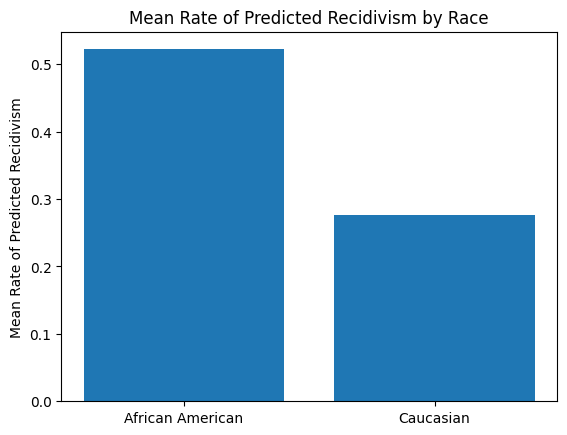

In [ ]:
import matplotlib.pyplot as plt

# Calculate the mean rate of "predicted to recidivate" for African American and Caucasian individuals
african_americans = results[results['race'] == 0]  # Assuming '0' corresponds to 'African-American'
caucasians = results[results['race'] == 2]  # Assuming '2' corresponds to 'Caucasian'

mean_predicted_recidivate_aa = african_americans['predicted_label'].mean()
mean_predicted_recidivate_c = caucasians['predicted_label'].mean()

# Calculate the difference
diff = mean_predicted_recidivate_aa - mean_predicted_recidivate_c

print(f"Mean rate of predicted to recidivate for African Americans: {mean_predicted_recidivate_aa:.4f}")
print(f"Mean rate of predicted to recidivate for Caucasians: {mean_predicted_recidivate_c:.4f}")
print(f"Difference between the mean rates: {diff:.4f}")

# Plot the difference
plt.bar(['African American', 'Caucasian'], [mean_predicted_recidivate_aa, mean_predicted_recidivate_c])
plt.ylabel('Mean Rate of Predicted Recidivism')
plt.title('Mean Rate of Predicted Recidivism by Race')
plt.show()


# Question 2

In [ ]:
# Calculate the probability of a individual recidivates for individuals who are predicted positive by your algorithm, for each race
print("0 - African American , 2 - Caucasian")
for race in races:
    numerator = len(results[(results['race'] == race) & (results['predicted_label'] == 1) & (results['true_label'] == 1)])
    denominator = len(results[(results['race'] == race) & (results['predicted_label'] == 1)])
    prob_pos_pred = numerator / denominator
    print(f"Probability of a individual recidivates for {race} individuals who are predicted positive by algorithm: {prob_pos_pred:.2f} ({numerator}/{denominator})")



0 - African American , 2 - Caucasian
Probability of a individual recidivates for 0 individuals who are predicted positive by algorithm: 0.68 (386/571)
Probability of a individual recidivates for 5 individuals who are predicted positive by algorithm: 0.48 (12/25)
Probability of a individual recidivates for 2 individuals who are predicted positive by algorithm: 0.62 (123/199)
Probability of a individual recidivates for 3 individuals who are predicted positive by algorithm: 0.67 (29/43)
Probability of a individual recidivates for 4 individuals who are predicted positive by algorithm: 1.00 (3/3)
Probability of a individual recidivates for 1 individuals who are predicted positive by algorithm: 1.00 (2/2)


# Without Considering Race

In [ ]:
Data_noRace = datas.drop('race', axis=1)
Data_noRace.columns

Index(['age', 'c_charge_degree', 'age_cat', 'score_text', 'sex',
       'priors_count', 'days_b_screening_arrest', 'decile_score',
       'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'two_year_recid',
       'length_of_stay'],
      dtype='object')

In [ ]:
# Select features and target
X2 = Data_noRace.drop('two_year_recid', axis=1)
y2 = Data_noRace['two_year_recid']

# Perform the train-test split
X2_train, X2_test, y2_train, y2_test= train_test_split(X2, y2, test_size=0.33, random_state=42)


In [ ]:
scaler = StandardScaler()
X2_train_scaled = scaler.fit_transform(X2_train)
X2_test_scaled = scaler.transform(X2_test)

In [ ]:
# Train and evaluate the best classifier on the test set
best_classifier = GradientBoostingClassifier() 
best_classifier.fit(X2_train, y2_train)
y2_pred = best_classifier.predict(X2_test)
accuracy = accuracy_score(y2_test, y2_pred)
print(f"Best classifier - Accuracy: {accuracy:.4f}")
print(classification_report(y2_test, y2_pred))
cm = confusion_matrix(y2_test, y2_pred)
cm_df = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])

# Calculate the counts of true positives, true negatives, false positives, and false negatives
tp = cm_df.loc['Actual Positive', 'Predicted Positive']
tn = cm_df.loc['Actual Negative', 'Predicted Negative']
fp = cm_df.loc['Actual Negative', 'Predicted Positive']
fn = cm_df.loc['Actual Positive', 'Predicted Negative']

# Print the confusion matrix with counts of true positives, true negatives, false positives, and false negatives
print(f"Confusion Matrix:\n{cm_df}\n")
print(f"True Positives: {tp}")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")

Best classifier - Accuracy: 0.6830
              precision    recall  f1-score   support

           0       0.70      0.76      0.73      1194
           1       0.66      0.59      0.62       945

    accuracy                           0.68      2139
   macro avg       0.68      0.67      0.67      2139
weighted avg       0.68      0.68      0.68      2139

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                 902                 292
Actual Positive                 386                 559

True Positives: 559
True Negatives: 902
False Positives: 292
False Negatives: 386


# Question 1 (Without Race)

In [ ]:
results = pd.DataFrame({"true_label": y_test, "predicted_label": y_pred, "race": X_test['race']})

# Get the list of unique races in the dataset
races = results['race'].unique()

print("0 - African American , 2 - Caucasian")
# Calculate the probability of a positive prediction for individuals who did not actually recidivate, for each race
for race in races:
    numerator = len(results[(results['race'] == race) & (results['true_label'] == 0) & (results['predicted_label'] == 1)])
    denominator = len(results[(results['race'] == race) & (results['true_label'] == 0)])
    prob_pos_pred = numerator / denominator
    print(f"Probability of a positive prediction for {race} individuals who did not actually recidivate: {prob_pos_pred:.2f} ({numerator}/{denominator})")


# 0 - African American , 2 - Caucasian

0 - African American , 2 - Caucasian
Probability of a positive prediction for 0 individuals who did not actually recidivate: 0.34 (185/540)
Probability of a positive prediction for 5 individuals who did not actually recidivate: 0.15 (13/84)
Probability of a positive prediction for 2 individuals who did not actually recidivate: 0.17 (76/440)
Probability of a positive prediction for 3 individuals who did not actually recidivate: 0.12 (14/121)
Probability of a positive prediction for 4 individuals who did not actually recidivate: 0.00 (0/2)
Probability of a positive prediction for 1 individuals who did not actually recidivate: 0.00 (0/7)


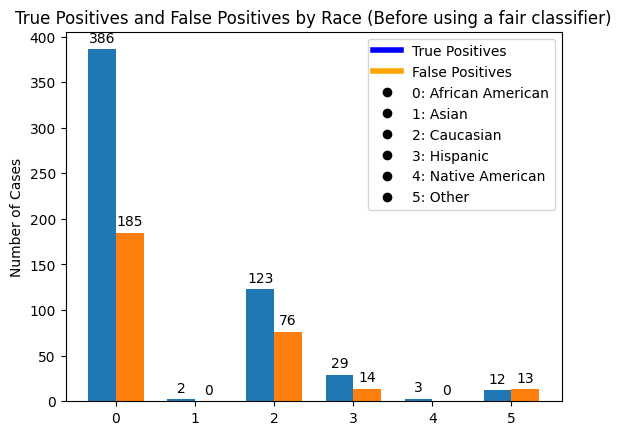

In [ ]:
import numpy as np

# Calculate true positives and false positives for each race
true_positives = {}
false_positives = {}

for race in races:
    race_results = results[results['race'] == race]

    # True Positives: predicted_label = 1, true_label = 1
    tp = race_results[(race_results['predicted_label'] == 1) & (race_results['true_label'] == 1)].shape[0]

    # False Positives: predicted_label = 1, true_label = 0
    fp = race_results[(race_results['predicted_label'] == 1) & (race_results['true_label'] == 0)].shape[0]

    true_positives[race] = tp
    false_positives[race] = fp

# Create a list of race labels corresponding to the encoded values in 'races'
races_labels = ['African American', 'Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other']
races_encoded = sorted(races)
races_dict = dict(zip(races_encoded, races_labels))

# Plot true positives and false positives
bar_width = 0.35

fig, ax = plt.subplots()

bar1 = ax.bar([x - bar_width / 2 for x in range(len(races_encoded))], [true_positives[race] for race in races_encoded], bar_width)
bar2 = ax.bar([x + bar_width / 2 for x in range(len(races_encoded))], [false_positives[race] for race in races_encoded], bar_width)

# Function to display the value of each bar inside the bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height}",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)

ax.set_xticks(range(len(races_encoded)))
ax.set_xticklabels(races_encoded)

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='blue', lw=4, label='True Positives'),
    Line2D([0], [0], color='orange', lw=4, label='False Positives')
] + [Line2D([0], [0], marker='o', color='w', label=f"{race}: {races_dict[race]}", markerfacecolor='black', markersize=8) for race in races_encoded]

ax.legend(handles=legend_elements, loc='upper right')

plt.ylabel('Number of Cases')
plt.title('True Positives and False Positives by Race (Before using a fair classifier)')
plt.show()


Mean rate of predicted to recidivate for African Americans: 0.5219
Mean rate of predicted to recidivate for Caucasians: 0.2768
Difference between the mean rates: 0.2452


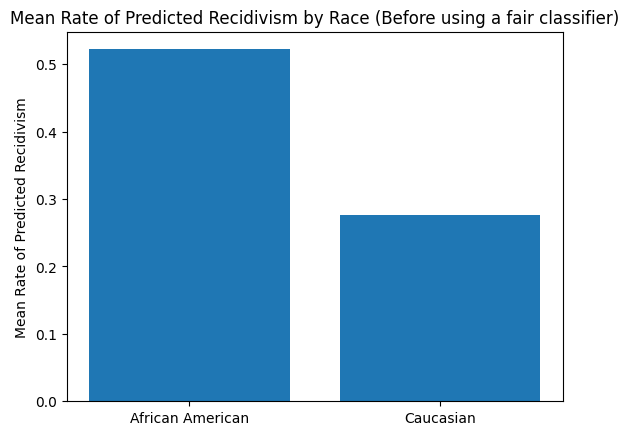

In [ ]:
import matplotlib.pyplot as plt

# Calculate the mean rate of "predicted to recidivate" for African American and Caucasian individuals
african_americans = results[results['race'] == 0]  # Assuming '0' corresponds to 'African-American'
caucasians = results[results['race'] == 2]  # Assuming '2' corresponds to 'Caucasian'

mean_predicted_recidivate_aa = african_americans['predicted_label'].mean()
mean_predicted_recidivate_c = caucasians['predicted_label'].mean()

# Calculate the difference
diff = mean_predicted_recidivate_aa - mean_predicted_recidivate_c

print(f"Mean rate of predicted to recidivate for African Americans: {mean_predicted_recidivate_aa:.4f}")
print(f"Mean rate of predicted to recidivate for Caucasians: {mean_predicted_recidivate_c:.4f}")
print(f"Difference between the mean rates: {diff:.4f}")

# Plot the difference
plt.bar(['African American', 'Caucasian'], [mean_predicted_recidivate_aa, mean_predicted_recidivate_c])
plt.ylabel('Mean Rate of Predicted Recidivism')
plt.title('Mean Rate of Predicted Recidivism by Race (Before using a fair classifier)')
plt.show()


# Question 2 (Without Race)

In [ ]:
# Calculate the probability of a individual recidivates for individuals who are predicted positive by your algorithm, for each race
print("0 - African American , 2 - Caucasian")
for race in races:
    numerator = len(results[(results['race'] == race) & (results['predicted_label'] == 1) & (results['true_label'] == 1)])
    denominator = len(results[(results['race'] == race) & (results['predicted_label'] == 1)])
    prob_pos_pred = numerator / denominator
    print(f"Probability of a individual recidivates for {race} individuals who are predicted positive by algorithm: {prob_pos_pred:.2f} ({numerator}/{denominator})")



0 - African American , 2 - Caucasian
Probability of a individual recidivates for 0 individuals who are predicted positive by algorithm: 0.68 (386/571)
Probability of a individual recidivates for 5 individuals who are predicted positive by algorithm: 0.48 (12/25)
Probability of a individual recidivates for 2 individuals who are predicted positive by algorithm: 0.62 (123/199)
Probability of a individual recidivates for 3 individuals who are predicted positive by algorithm: 0.67 (29/43)
Probability of a individual recidivates for 4 individuals who are predicted positive by algorithm: 1.00 (3/3)
Probability of a individual recidivates for 1 individuals who are predicted positive by algorithm: 1.00 (2/2)


# Using a classifier designed to be more fair

In [ ]:
# Select features and target
X = datas.drop('two_year_recid', axis=1)
y = datas['two_year_recid']

# Perform the train-test split
X_train, X_test, y_train, y_test, race_tr, race_te = train_test_split(X, y, X['race'], test_size=0.33, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Define the sensitive features
sensitive_features_train = X_train['race']
sensitive_features_test = X_test['race']

# Create the base estimator
base_estimator = GradientBoostingClassifier()

# Wrap the base estimator with ExponentiatedGradient and EqualizedOdds constraint
equal_op_clf = ExponentiatedGradient(base_estimator, constraints=EqualizedOdds())

# Fit the equal opportunity classifier to the training data
equal_op_clf.fit(X_train, y_train, sensitive_features=sensitive_features_train)


ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.EqualizedOdds object at 0x7f5713a01630>,
                      estimator=GradientBoostingClassifier(),
                      nu=0.003417354155345123)

In [ ]:
# Predict the test data
y_pred = equal_op_clf.predict(X_test)

# Calculate the equalized odds difference
equal_op_difference = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_features_test)
print("Equalized Odds Difference:", equal_op_difference)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])

# Calculate the counts of true positives, true negatives, false positives, and false negatives
tp = cm_df.loc['Actual Positive', 'Predicted Positive']
tn = cm_df.loc['Actual Negative', 'Predicted Negative']
fp = cm_df.loc['Actual Negative', 'Predicted Positive']
fn = cm_df.loc['Actual Positive', 'Predicted Negative']

# Print the confusion matrix with counts of true positives, true negatives, false positives, and false negatives
print(f"Confusion Matrix:\n{cm_df}\n")
print(f"True Positives: {tp}")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")

Equalized Odds Difference: 0.29174712450675844
              precision    recall  f1-score   support

           0       0.70      0.78      0.73      1194
           1       0.67      0.57      0.62       945

    accuracy                           0.69      2139
   macro avg       0.68      0.67      0.67      2139
weighted avg       0.68      0.69      0.68      2139

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                 926                 268
Actual Positive                 405                 540

True Positives: 540
True Negatives: 926
False Positives: 268
False Negatives: 405


In [ ]:
results = pd.DataFrame({"true_label": y_test, "predicted_label": y_pred, "race": race_te})

# Get the list of unique races in the dataset
unique_races = results['race'].unique()

print("0 - African American , 2 - Caucasian")
# Calculate the probability of a positive prediction for individuals who did not actually recidivate, for each race
for race in unique_races:
    numerator = len(results[(results['race'] == race) & (results['true_label'] == 0) & (results['predicted_label'] == 1)])
    denominator = len(results[(results['race'] == race) & (results['true_label'] == 0)])
    prob_pos_pred = numerator / denominator
    print(f"Probability of a positive prediction for {race} individuals who did not actually recidivate: {prob_pos_pred:.2f} ({numerator}/{denominator})")


# 0 - African American , 2 - Caucasian

0 - African American , 2 - Caucasian
Probability of a positive prediction for 0 individuals who did not actually recidivate: 0.24 (128/540)
Probability of a positive prediction for 5 individuals who did not actually recidivate: 0.19 (16/84)
Probability of a positive prediction for 2 individuals who did not actually recidivate: 0.23 (102/440)
Probability of a positive prediction for 3 individuals who did not actually recidivate: 0.17 (21/121)
Probability of a positive prediction for 4 individuals who did not actually recidivate: 0.00 (0/2)
Probability of a positive prediction for 1 individuals who did not actually recidivate: 0.14 (1/7)


In [ ]:
import pandas as pd

results = pd.DataFrame({"true_label": y_test, "predicted_label": y_pred, "race": race_te})

# Get the list of unique races in the dataset
unique_races = results['race'].unique()

print("0 - African American , 2 - Caucasian")
# Calculate the false negatives for individuals who actually recidivated, for each race
for race in unique_races:
    numerator = len(results[(results['race'] == race) & (results['true_label'] == 1) & (results['predicted_label'] == 0)])
    denominator = len(results[(results['race'] == race) & (results['true_label'] == 1)])
    prob_false_neg = numerator / denominator
    print(f"False negative rate for {race} individuals who actually recidivated: {prob_false_neg:.2f} ({numerator}/{denominator})")

# 0 - African American , 2 - Caucasian


0 - African American , 2 - Caucasian
False negative rate for 0 individuals who actually recidivated: 0.38 (212/554)
False negative rate for 5 individuals who actually recidivated: 0.67 (29/43)
False negative rate for 2 individuals who actually recidivated: 0.47 (130/279)
False negative rate for 3 individuals who actually recidivated: 0.48 (31/64)
False negative rate for 4 individuals who actually recidivated: 0.67 (2/3)
False negative rate for 1 individuals who actually recidivated: 0.50 (1/2)


In [ ]:
# Calculate the probability of a individual recidivates for individuals who are predicted positive by your algorithm, for each race
print("0 - African American , 2 - Caucasian")
for race in unique_races:
    numerator = len(results[(results['race'] == race) & (results['predicted_label'] == 1) & (results['true_label'] == 1)])
    denominator = len(results[(results['race'] == race) & (results['predicted_label'] == 1)])
    prob_pos_pred = numerator / denominator
    print(f"Probability of a individual recidivates for {race} individuals who are predicted positive by algorithm: {prob_pos_pred:.2f} ({numerator}/{denominator})")



0 - African American , 2 - Caucasian
Probability of a individual recidivates for 0 individuals who are predicted positive by algorithm: 0.73 (342/470)
Probability of a individual recidivates for 5 individuals who are predicted positive by algorithm: 0.47 (14/30)
Probability of a individual recidivates for 2 individuals who are predicted positive by algorithm: 0.59 (149/251)
Probability of a individual recidivates for 3 individuals who are predicted positive by algorithm: 0.61 (33/54)
Probability of a individual recidivates for 4 individuals who are predicted positive by algorithm: 1.00 (1/1)
Probability of a individual recidivates for 1 individuals who are predicted positive by algorithm: 0.50 (1/2)


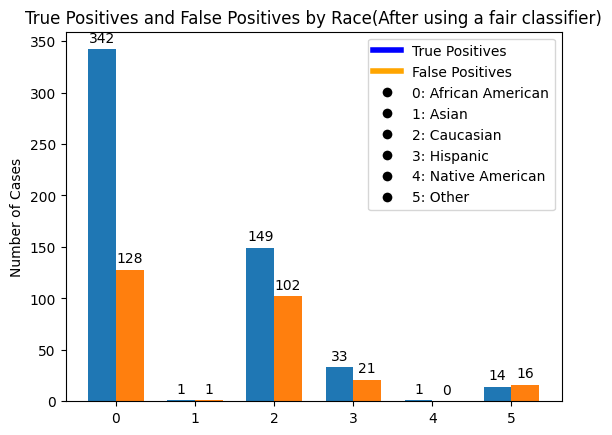

In [ ]:
import numpy as np

# Calculate true positives and false positives for each race
true_positives = {}
false_positives = {}

for race in races:
    race_results = results[results['race'] == race]

    # True Positives: predicted_label = 1, true_label = 1
    tp = race_results[(race_results['predicted_label'] == 1) & (race_results['true_label'] == 1)].shape[0]

    # False Positives: predicted_label = 1, true_label = 0
    fp = race_results[(race_results['predicted_label'] == 1) & (race_results['true_label'] == 0)].shape[0]

    true_positives[race] = tp
    false_positives[race] = fp

# Create a list of race labels corresponding to the encoded values in 'races'
races_labels = ['African American', 'Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other']
races_encoded = sorted(races)
races_dict = dict(zip(races_encoded, races_labels))

# Plot true positives and false positives
bar_width = 0.35

fig, ax = plt.subplots()

bar1 = ax.bar([x - bar_width / 2 for x in range(len(races_encoded))], [true_positives[race] for race in races_encoded], bar_width)
bar2 = ax.bar([x + bar_width / 2 for x in range(len(races_encoded))], [false_positives[race] for race in races_encoded], bar_width)

# Function to display the value of each bar inside the bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height}",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)

ax.set_xticks(range(len(races_encoded)))
ax.set_xticklabels(races_encoded)

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='blue', lw=4, label='True Positives'),
    Line2D([0], [0], color='orange', lw=4, label='False Positives')
] + [Line2D([0], [0], marker='o', color='w', label=f"{race}: {races_dict[race]}", markerfacecolor='black', markersize=8) for race in races_encoded]

ax.legend(handles=legend_elements, loc='upper right')

plt.ylabel('Number of Cases')
plt.title('True Positives and False Positives by Race(After using a fair classifier)')
plt.show()


Mean rate of predicted to recidivate for African Americans: 0.4296
Mean rate of predicted to recidivate for Caucasians: 0.3491
Difference between the mean rates: 0.0805


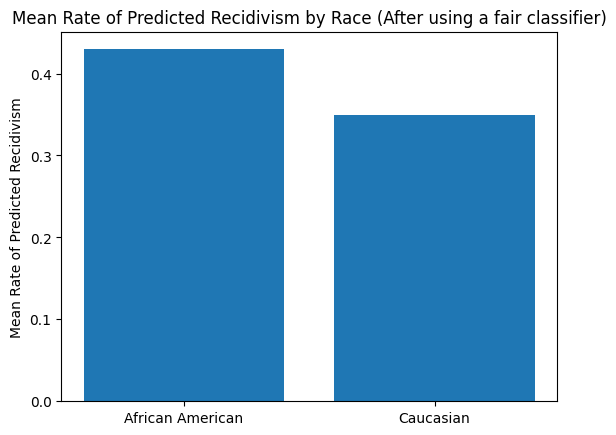

In [ ]:
import matplotlib.pyplot as plt

# Calculate the mean rate of "predicted to recidivate" for African American and Caucasian individuals
african_americans = results[results['race'] == 0]
caucasians = results[results['race'] == 2]

mean_predicted_recidivate_aa = african_americans['predicted_label'].mean()
mean_predicted_recidivate_c = caucasians['predicted_label'].mean()

# Calculate the difference
diff = mean_predicted_recidivate_aa - mean_predicted_recidivate_c

print(f"Mean rate of predicted to recidivate for African Americans: {mean_predicted_recidivate_aa:.4f}")
print(f"Mean rate of predicted to recidivate for Caucasians: {mean_predicted_recidivate_c:.4f}")
print(f"Difference between the mean rates: {diff:.4f}")

# Plot the difference
plt.bar(['African American', 'Caucasian'], [mean_predicted_recidivate_aa, mean_predicted_recidivate_c])
plt.ylabel('Mean Rate of Predicted Recidivism')
plt.title('Mean Rate of Predicted Recidivism by Race (After using a fair classifier)')
plt.show()
